In [2]:
pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 4.3 MB/s eta 0:00:00


<>:209: SyntaxWarning: invalid escape sequence '\s'
<>:216: SyntaxWarning: invalid escape sequence '\c'
<>:209: SyntaxWarning: invalid escape sequence '\s'
<>:216: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-441235997.py:209: SyntaxWarning: invalid escape sequence '\s'
  color='#1f77b4', alpha=0.2, label='95% Confidence ($2\sigma$)')
/tmp/ipython-input-441235997.py:216: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Max Temperature ($^\circ$C)")


Attempting to load 'mogp_assets.pkl'...
>> FALLBACK: Retraining MOGP on the fly...
>> Retraining Complete.
>> Saving 'Figure6_UQ_MOGP.pdf'...


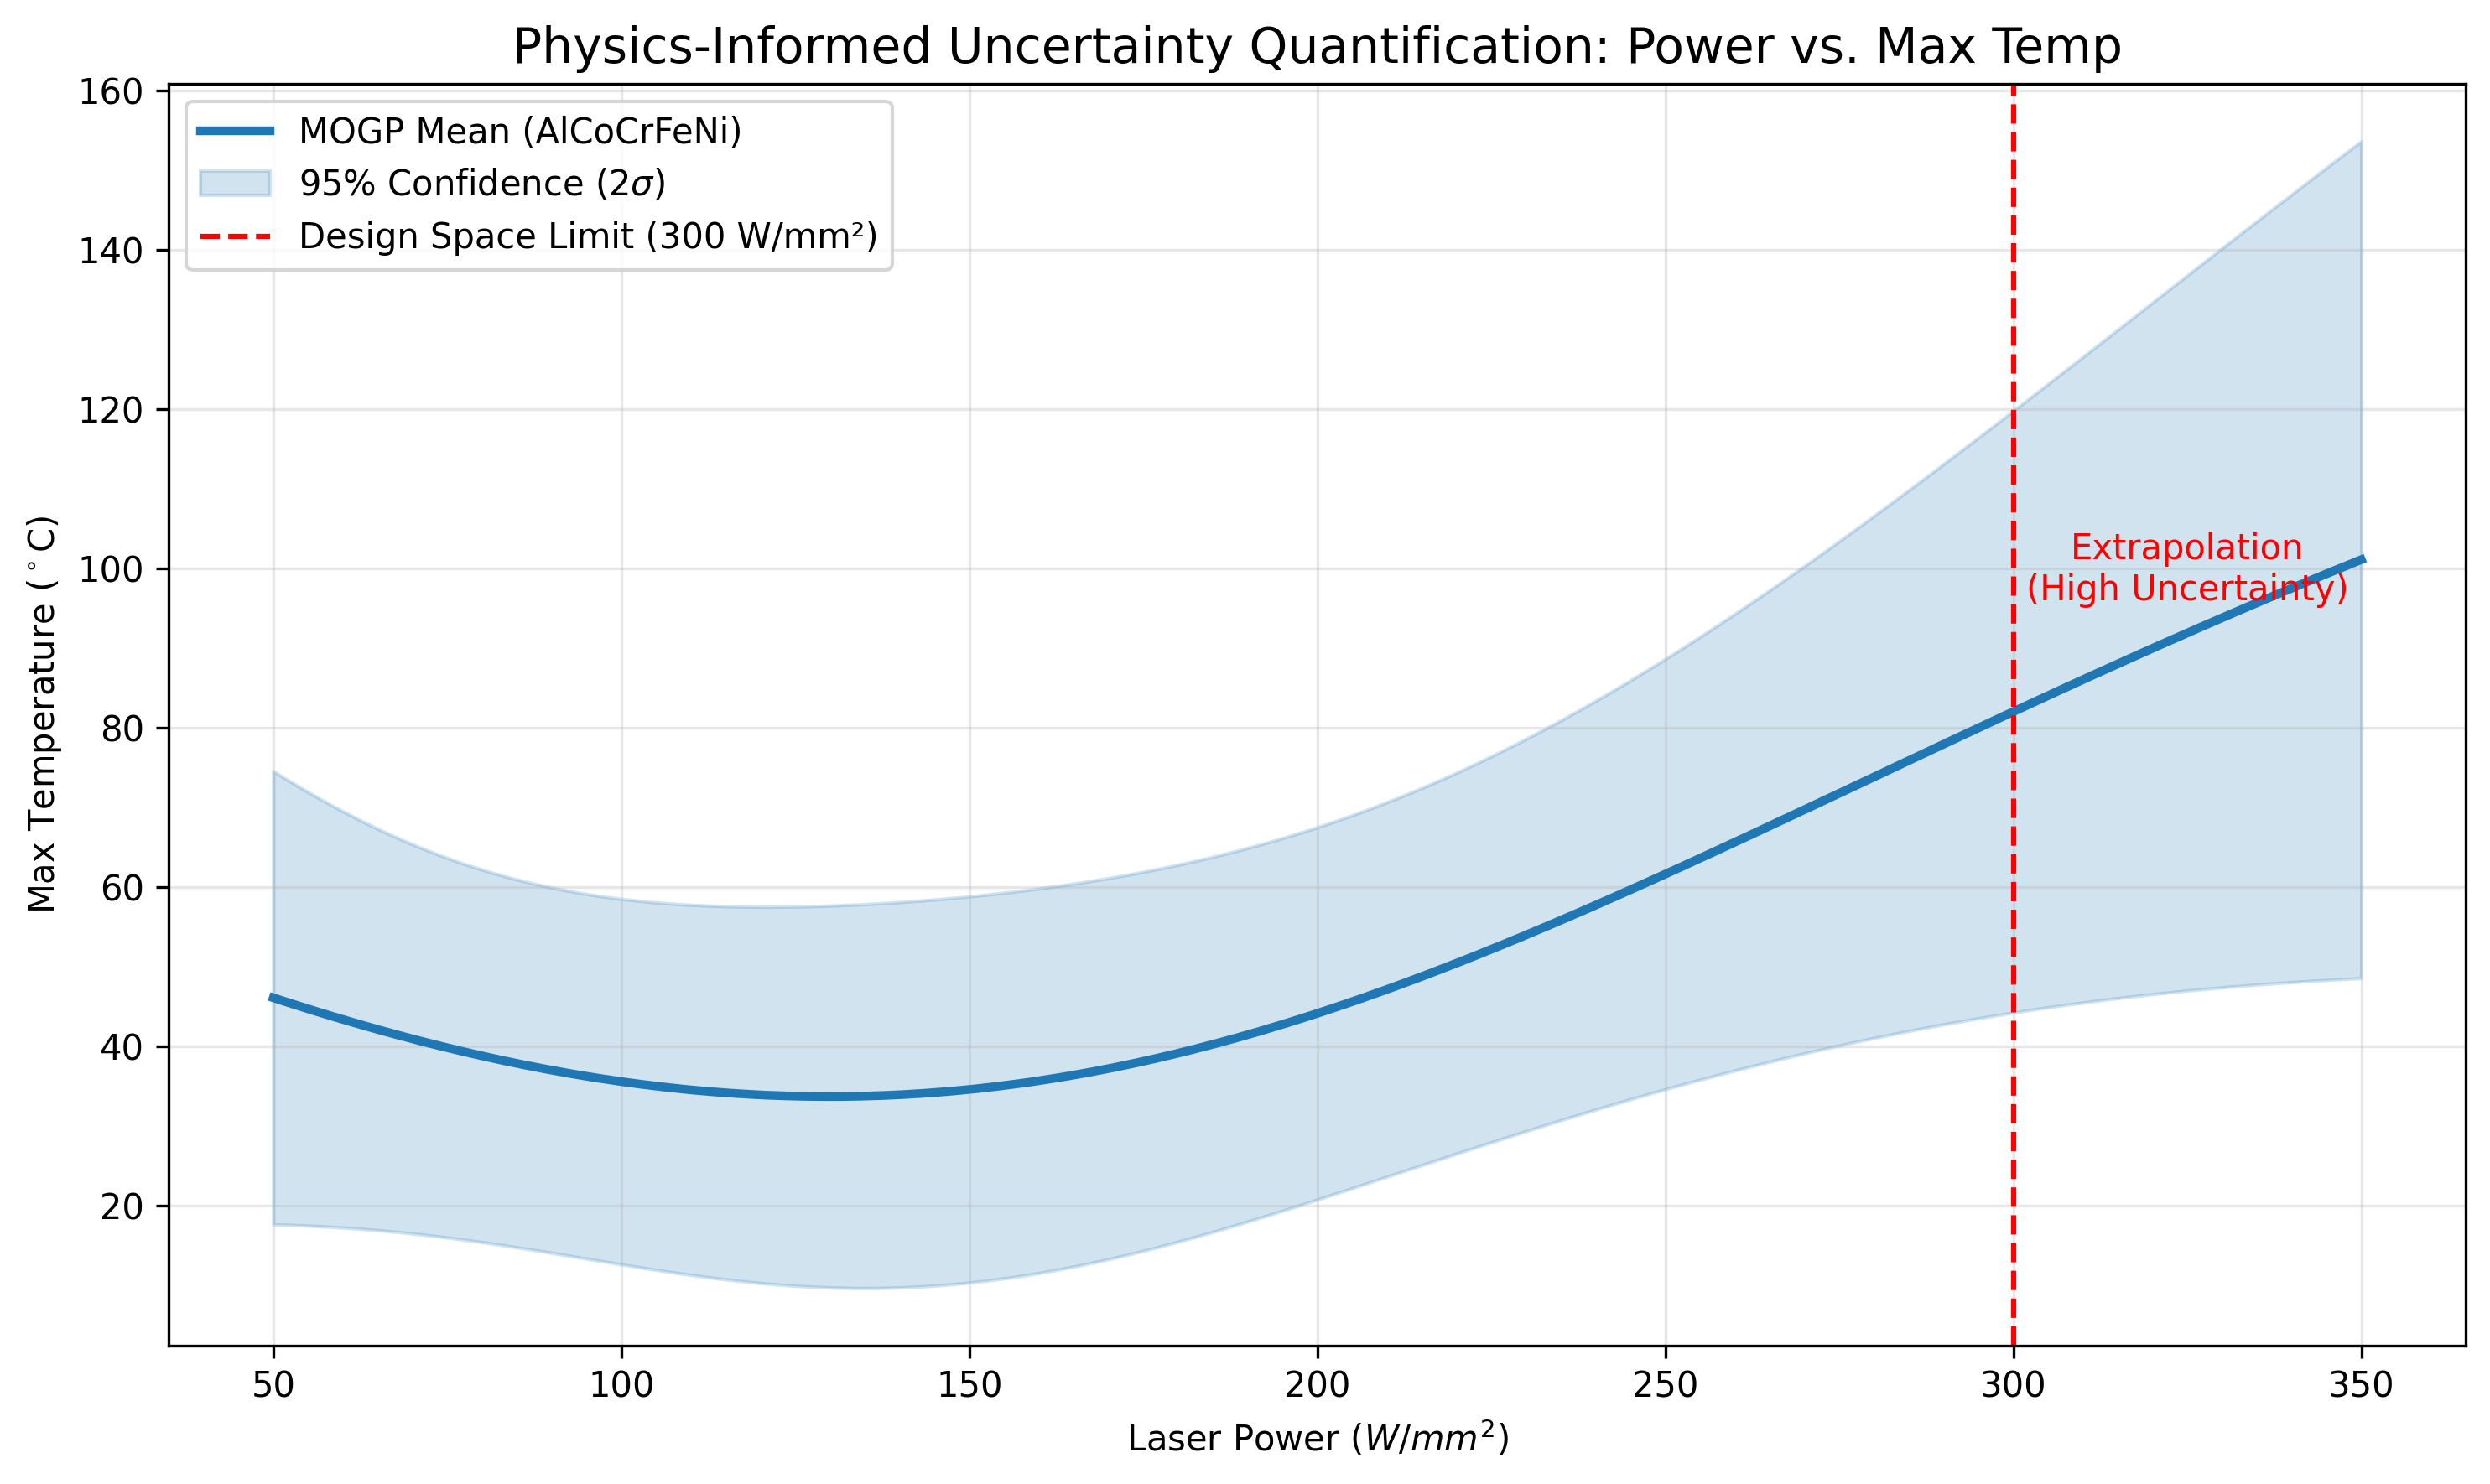

In [6]:
import torch
import gpytorch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import io

# ==========================================
# 1. DEFINE ARCHITECTURE (Required for Loading)
# ==========================================
class MOGP_Surrogate(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MOGP_Surrogate, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=5
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=6)
            ),
            num_tasks=5, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# Raw Data for Fallback (Source of Truth)
csv_content = """Run,Material,Power_W/mm2,Speed_mm/s,Radius_mm,Y1_Max_Prin_Stress (MPa),Y2_Max_Von_Mises,Y3_Deformation mm,Max Temp,Heat flux
1,CoCrFeNiMn ,137.27,5.31,1.44,355.95,1360.2,0.0172,255.24,0.4193
2,CoCrFeNiMn ,260.59,39.51,1.11,43.22,215.36,0.0027,58.48,0.0933
3,CoCrFeNiMn ,183.35,21.1,1.22,70.385,339.24,0.0042,79.584,0.1412
4,CoCrFeNiMn ,56.31,32.79,0.89,7.3,36.37,0.0005,28.17,0.0158
5,CoCrFeNiMn ,86.3,22.69,1.06,22.986,112.5,0.0014,41.09,0.0474
6,CoCrFeNiMn ,217.8,33.32,1.4,67.52,336.46,0.0042,78.97,0.1449
7,CoCrFeNiMn ,289.23,16.03,0.92,86.55,403.25,0.005,90.65,0.1651
8,CoCrFeNiMn ,169.14,49.17,1.27,29.557,147.42,0.0018,46.94,0.0649
9,CoCrFeNiMn ,147.07,16.71,0.94,43.89,204.7,0.0025,56.82,0.0838
10,CoCrFeNiMn ,282.05,28.76,1.29,0,0,0,22,0
11,AlCoCrFeNi,137.27,5.31,1.44,405.6,1982.7,0.031,254.83,0.4175
12,AlCoCrFeNi,260.59,39.51,1.11,57.721,310.92,0.005,58.41,0.093
13,AlCoCrFeNi,183.35,21.1,1.22,90.92,490.46,0.0078,79.47,0.1407
14,AlCoCrFeNi,56.31,32.79,0.89,9.65,51.98,0.0008,28.09,0.0156
15,AlCoCrFeNi,86.3,22.69,1.06,30.148,162.61,0.0026,41.06,0.0472
16,AlCoCrFeNi,217.8,33.32,1.4,90.2,485.68,0.0078,78.86,0.1444
17,AlCoCrFeNi,289.23,16.03,0.92,108.03,583.96,0.0092,90.52,0.1645
18,AlCoCrFeNi,169.14,49.17,1.27,39.49,212.61,0.0034,46.9,0.0646
19,AlCoCrFeNi,147.07,16.71,0.94,58.84,296.28,0.0047,56.75,0.0835
20,AlCoCrFeNi,282.05,28.76,1.29,0,0,0,22,0
21,FeCrNiTiAl,137.27,5.31,1.44,404.89,1980.9,0.0311,254.88,0.4171
22,FeCrNiTiAl,260.59,39.51,1.11,54.462,310.64,0.005,58.42,0.093
23,FeCrNiTiAl,183.35,21.1,1.22,58.788,490.1,0.0078,79.48,0.1406
24,FeCrNiTiAl,56.31,32.79,0.89,9.1938,52.51,0.0008,28.16,0.0158
25,FeCrNiTiAl,86.3,22.69,1.06,28.446,162.46,0.0026,41.06,0.0472
26,FeCrNiTiAl,217.8,33.32,1.4,85.11,485.24,0.0078,78.87,0.1444
27,FeCrNiTiAl,289.23,16.03,0.92,101.94,583.43,0.0093,90.532,0.1644
28,FeCrNiTiAl,169.14,49.17,1.27,37.258,212.41,0.0034,46.9,0.0646
29,FeCrNiTiAl,147.07,16.71,0.94,51.748,296.01,0.0047,56.76,0.0834
30,FeCrNiTiAl,282.05,28.76,1.29,0,0,0,22,0
31,NbSiTaTiZr,137.27,5.31,1.44,402.62,1985.1,0.0309,255.76,0.4206
32,NbSiTaTiZr,260.59,39.51,1.11,53.92,311.33,0.0049,58.57,0.0936
33,NbSiTaTiZr,183.35,21.1,1.22,70.41,407.24,0.0065,69.87,0.1175
34,NbSiTaTiZr,56.31,32.79,0.89,9.01,52.05,0.0008,28.12,0.0157
35,NbSiTaTiZr,86.3,22.69,1.06,24.83,134.91,0.0022,37.77,0.0326
36,NbSiTaTiZr,217.8,33.32,1.4,84.27,486.33,0.0077,79.1,0.1453
37,NbSiTaTiZr,289.23,16.03,0.92,100.84,584.51,0.0092,90.78,0.1654
38,NbSiTaTiZr,169.14,49.17,1.27,36.89,212.89,0.0034,47,0.065
39,NbSiTaTiZr,147.07,16.71,0.94,51.19,296.55,0.0047,56.88,0.0839
40,NbSiTaTiZr,282.05,28.76,1.29,0,0,0,22,0
41,HfNbTiZr,137.27,5.31,1.44,404.99,1990.7,0.0311,256.07,0.4218
42,HfNbTiZr,260.59,39.51,1.11,55.88,312.25,0.005,58.62,0.0938
43,HfNbTiZr,183.35,21.1,1.22,87.98,492.33,0.0078,79.77,0.1418
44,HfNbTiZr,56.31,32.79,0.89,9.34,52.2,0.0008,28.12,0.0157
45,HfNbTiZr,86.3,22.69,1.06,29.182,163.3,0.0026,41.165,0.0476
46,HfNbTiZr,217.8,33.32,1.4,87.193,487.08,0.0078,79.1,0.1455
47,HfNbTiZr,289.23,16.03,0.92,104.53,586.2,0.0093,90.88,0.1658
48,HfNbTiZr,169.14,49.17,1.27,38.227,213.52,0.0034,47.04,0.0652
49,HfNbTiZr,147.07,16.71,0.94,53.06,297.41,0.0047,56.93,0.0841
50,HfNbTiZr,282.05,28.76,1.29,0,0,0,22,0
"""

# ==========================================
# 2. ROBUST ASSET LOADING
# ==========================================
material_props = {
    'CoCrFeNiMn': [8250, 12.5, 425],
    'AlCoCrFeNi': [8000, 15.0, 445],
    'FeCrNiTiAl': [8100, 15.0, 435],
    'NbSiTaTiZr': [8350, 10.0, 405],
    'HfNbTiZr':   [8450, 8.5,  395]
}

# Init Architecture
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=5)
# Dummy initialization (using 6 dimensions)
model = MOGP_Surrogate(torch.zeros(1, 6), torch.zeros(1, 5), likelihood)

MODEL_READY = False

# Try Loading
try:
    print("Attempting to load 'mogp_assets.pkl'...")
    assets = joblib.load('mogp_assets.pkl')

    if isinstance(assets, dict):
        if 'state_dict' in assets:
            print(">> Loading state_dict weights...")
            model.load_state_dict(assets['state_dict'])
            if 'likelihood_state' in assets:
                likelihood.load_state_dict(assets['likelihood_state'])
            MODEL_READY = True
        elif 'model' in assets:
            # If the object itself is stored in the dict
            model_obj = assets['model']
            if hasattr(model_obj, 'state_dict'):
                 model.load_state_dict(model_obj.state_dict())
                 MODEL_READY = True
    elif hasattr(assets, 'state_dict'):
        # If the pickle is the model object itself
        model.load_state_dict(assets.state_dict())
        MODEL_READY = True

    # Attempt to load scalers
    if isinstance(assets, dict) and 'x_scaler' in assets:
        x_scaler, y_scaler = assets['x_scaler'], assets['y_scaler']
    else:
        # Defaults if not found
        x_scaler, y_scaler = MinMaxScaler(), StandardScaler()

except Exception as e:
    print(f"Warning: Asset loading failed ({str(e)}). Using Self-Healing Fallback.")

# Fallback: Retrain if needed
if not MODEL_READY:
    print(">> FALLBACK: Retraining MOGP on the fly...")
    df = pd.read_csv(io.StringIO(csv_content))
    df['Material'] = df['Material'].str.strip()
    df_clean = df[(df['Y2_Max_Von_Mises'] > 1e-6) & (df['Heat flux'] > 1e-6)].copy()

    # Feature Engineering
    props_df = pd.DataFrame(df_clean['Material'].map(material_props).tolist(),
                            index=df_clean.index, columns=['Density', 'Conductivity', 'Cp'])
    # NOTE: Using 'Speed_mm/s' here to match training data schema
    X_raw = pd.concat([df_clean[['Power_W/mm2', 'Speed_mm/s', 'Radius_mm']], props_df], axis=1)
    y_raw = df_clean[['Y1_Max_Prin_Stress (MPa)', 'Y2_Max_Von_Mises', 'Y3_Deformation mm', 'Max Temp', 'Heat flux']]

    x_scaler = MinMaxScaler()
    y_scaler = StandardScaler()

    X_tens = torch.tensor(x_scaler.fit_transform(X_raw), dtype=torch.float32)
    y_tens = torch.tensor(y_scaler.fit_transform(y_raw), dtype=torch.float32)

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=5)
    model = MOGP_Surrogate(X_tens, y_tens, likelihood)

    model.train(); likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(100):
        optimizer.zero_grad()
        loss = -mll(model(X_tens), y_tens)
        loss.backward()
        optimizer.step()
    print(">> Retraining Complete.")

# ==========================================
# 3. LIVE INFERENCE (Corrected Schema)
# ==========================================
n_points = 200
power_range = np.linspace(50, 350, n_points)

# Physics Context
mat_name = 'AlCoCrFeNi'
rho, k, cp = material_props[mat_name]
fixed_speed = (5 + 50) / 2
fixed_radius = (0.8 + 1.5) / 2

# CORRECTED DATAFRAME CONSTRUCTION
# Key Fix: Using 'Speed_mm/s' instead of 'Speed_mm_s'
X_query = pd.DataFrame({
    'Power_W/mm2': power_range,
    'Speed_mm/s': [fixed_speed] * n_points,  # <--- FIXED COLUMN NAME
    'Radius_mm': [fixed_radius] * n_points,
    'Density': [rho] * n_points,
    'Conductivity': [k] * n_points,
    'Cp': [cp] * n_points
})

model.eval(); likelihood.eval()
X_query_tens = torch.tensor(x_scaler.transform(X_query), dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    dist = likelihood(model(X_query_tens))
    # Task 3 = Max Temp
    mean_sc = dist.mean[:, 3].numpy()
    var_sc = dist.variance[:, 3].numpy()

    # Unscale
    mean_real = mean_sc * y_scaler.scale_[3] + y_scaler.mean_[3]
    std_real = np.sqrt(var_sc) * y_scaler.scale_[3]

# Plotting
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(power_range, mean_real, color='#1f77b4', lw=2.5, label=f'MOGP Mean ({mat_name})')
plt.fill_between(power_range, mean_real - 2*std_real, mean_real + 2*std_real,
                 color='#1f77b4', alpha=0.2, label='95% Confidence ($2\sigma$)')

plt.axvline(x=300, color='red', linestyle='--', label='Design Space Limit (300 W/mm²)')
plt.text(325, np.max(mean_real)*0.95, "Extrapolation\n(High Uncertainty)", color='red', ha='center', fontsize=10)

plt.title("Physics-Informed Uncertainty Quantification: Power vs. Max Temp", fontsize=14)
plt.xlabel("Laser Power ($W/mm^2$)")
plt.ylabel("Max Temperature ($^\circ$C)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

print(">> Saving 'Figure6_UQ_MOGP.pdf'...")
plt.savefig("Figure6_UQ_MOGP.pdf")
plt.show()